In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

from scipy.stats import probplot
from scipy.stats import normaltest


from joblib import dump, load

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
from ML_Train.CNN_Classifier import  build_classifier_from_vae, create_vae, create_classifier
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

Using TensorFlow backend.


In [ ]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [ ]:
train_featuresDF = pd.read_csv('data/featuresDF_train.csv')
train_stats = pd.read_csv('data/stats_train.csv')
train_vibState = pd.read_csv('data/vibState_train.csv')

valid_featuresDF = pd.read_csv('data/featuresDF_valid.csv')
valid_stats = pd.read_csv('data/stats_valid.csv')
valid_vibState = pd.read_csv('data/vibState_valid.csv')


In [ ]:
enc = OrdinalEncoder()
X_train = train_featuresDF.values[:,1:1025].astype(np.float32)
Y_train = enc.fit_transform(train_vibState.values[:,1][...,np.newaxis])

X_valid = valid_featuresDF.values[:,1:1025].astype(np.float32)
Y_valid = enc.transform(valid_vibState.values[:,1][...,np.newaxis])

X_train_healthy = X_train[np.argwhere(Y_train.flatten()==0).flatten(),:]
Y_train_healthy = Y_train[np.argwhere(Y_train.flatten()==0).flatten()]
X_train_unhealthy = X_train[np.argwhere(Y_train.flatten()==1).flatten(),:]
Y_train_unhealthy = Y_train[np.argwhere(Y_train.flatten()==1).flatten()]

X_valid_healthy = X_valid[np.argwhere(Y_valid.flatten()==0).flatten(),:]
Y_valid_healthy = Y_valid[np.argwhere(Y_valid.flatten()==0).flatten()]
X_valid_unhealthy = X_valid[np.argwhere(Y_valid.flatten()==1).flatten(),:]
Y_valid_unhealthy = Y_valid[np.argwhere(Y_valid.flatten()==1).flatten()]

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

np.random.shuffle(XY_train)
np.random.shuffle(XY_valid)

X_train = XY_train[:,:-1]
Y_train = XY_train[:,-1]

X_valid = XY_valid[:,:-1]
Y_valid = XY_valid[:,-1]

num_samples = np.array([X_train.shape[0],
          X_valid.shape[0]])

max_samples = np.amax(num_samples)

In [5]:
def plot_confusion_matrix(y_true,y_pred,
                          labels,
                          filename='confusion_matrix'):
    
    predict_label = labels
    true_label = labels.copy()
    
    
    predict_label.insert(0, '')

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)

    fig = plt.figure()
    ax = plt.gca()
    im = ax.matshow(conf_matrix,cmap='RdBu')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true_label)
    ax.set_yticklabels(predict_label)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    xlabel = 'Actual State'
    ylabel = 'Predicted State'
    xlabelpad = 5

    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad)
    plt.ylabel(r'\textbf{' + ylabel + '}', labelpad=5)

    # Loop over data dimensions and create text annotations.
    for i in range(len(predict_label)-1):
        for j in range(len(true_label)):
            text = ax.text(j, i, conf_matrix[i, j],fontsize=22,
                           ha="center", va="center", color="w")

    plt.colorbar(im)
    plt.tight_layout()
    plt.savefig('Figures/' + filename + '.png',transparent=True)  
    plt.show()

array([['Healthy']], dtype=object)

In [10]:
estimators = [('reduce_dim', PCA(n_components=32)), ('gnb', GaussianNB())]
# estimators = [('reduce_dim', KernelPCA(n_components=32,kernel='rbf')), ('gmm', GaussianMixture())]

pipe = Pipeline(estimators)
pipe.fit(X_train,Y_train)

Y_valid_pred = pipe.predict(X_valid)
conf_matrix_valid = confusion_matrix(Y_valid, Y_valid_pred)
accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
print(conf_matrix_valid)
print(accuracy_valid)

Y_train_pred = pipe.predict(X_train)
conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
print(conf_matrix_train)
print(accuracy_train)

dump(pipe, 'data/pca_gnb.joblib') 

[[271 429]
 [ 89 611]]
0.63
[[627  73]
 [ 12 688]]
0.9392857142857143


['data/pca_gnb.joblib']

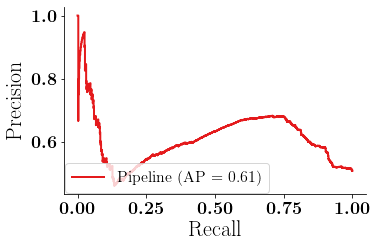

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


disp = plot_precision_recall_curve(pipe, X_valid, Y_valid)
disp.ax_.spines['right'].set_color('none')
disp.ax_.spines['top'].set_color('none')
disp.ax_.xaxis.set_ticks_position('bottom')
disp.ax_.yaxis.set_ticks_position('left')

In [12]:
X_valid.shape

(1400, 1024)

No handles with labels found to put in legend.


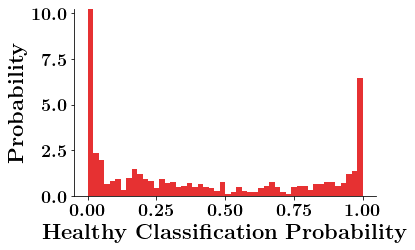

In [19]:
pipe.predict_proba(X_train_healthy)[:,0]

responses= np.vstack((
                       pipe.predict_proba(X_valid_healthy)[:,0]))
genplt.plot_histogram(responses,[''],
               'Healthy Classification Probability',
               'Probability',
               'pca_gnb_classifier_predict',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

In [192]:
def normalize_scores(scores,log_prob=False):
    
    if log_prob:
        scores = np.log(np.abs(scores - 1.1 * np.amax(scores)))
    
    norm_mean = np.mean(scores[:,0])
    norm_std = np.std(scores[:,0])
    
    scores = (scores - norm_mean) / norm_std
    
    [print(normaltest(scores[:,i])) for i in range(scores.shape[1])]
    [print(np.std(scores[:,i]), np.mean(scores[:,i])) for i in range(scores.shape[1])]
    
    return scores

In [22]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   filters, 
                   kernels, 
                   strides,
                   dilation_rates,
                   input_shape,
                   dense_nodes,
                   classes,
                   ):
    inputs = Input(shape=input_shape)
    x = inputs
    
    for i in range(len(filters)):
        x = Conv1D(filters=filters[i], 
                           kernel_size=kernels[i], 
                           strides=strides[i], 
                           activation='relu', 
                           padding='same',
                           dilation_rate=dilation_rates[i])(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(len(dense_nodes)):
        x = Dense(dense_nodes[i],activation='relu')(x)
        
    x = Dense(classes,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    return cnn_classifier

def create_classifier(param_dict):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
    dense_nodes = param_dict["dense_nodes"]
    classes = param_dict["classes"]
    
    classifier = build_classifier(filters,kernels,strides,dilation_rates,input_shape,dense_nodes,classes)
 
    return classifier
        

In [23]:
X_train[...,np.newaxis].shape

(1400, 1024, 1)

In [24]:
print(Y_train[...,np.newaxis].shape)
print(Y_valid[...,np.newaxis].shape)

(1400, 1)
(1400, 1)


In [51]:
if os.path.isfile('data/CNN-MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('data/CNN-MLP.h5')
    print(model.summary())
else:

    filters=[8,16,32]
    kernels = [3,3,3]
    strides=[1,1,1,1,1]
    dilation_rates=[1,1,1,1,1]
    input_shape = [1024,1]
    dense_nodes = [128,64]
    codings_size = 2

    param_dict = {
        "filters":filters,
        "kernels":kernels,
        "strides":strides,
        "dilation_rates":dilation_rates,
        "input_shape":input_shape,
        "dense_nodes":dense_nodes,
        "classes":2
    }
    # model,encoder,decoder = create_vae(param_dict)
    # model = create_classifier(param_dict)
    num_classes = 2
    model = create_classifier(param_dict)
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy'])
    loss = model.fit(
                X_train[...,np.newaxis],np.hstack((Y_train[...,np.newaxis],np.abs(Y_train[...,np.newaxis] - 1))),
#                 validation_split=0.2,
                validation_data=(X_valid[...,np.newaxis],np.hstack((Y_valid[...,np.newaxis],np.abs(Y_valid[...,np.newaxis] - 1)))),
                epochs=10,
                batch_size=8,
                verbose=1)
    
#     model.save('data/CNN-MLP.h5',save_format='tf')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(os.path.join('data', 'CNN-MLP.tflite',),
     "wb").write(tflite_model)

Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])

Y_cnn_train_pred = np.argmin(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmin(Y_cnn_valid_pred,axis=1)

Train on 1400 samples, validate on 1400 samples
Epoch 1/10
1400/1400 [==============================] - 2s 1ms/sample - loss: 0.4405 - accuracy: 0.8064 - val_loss: 0.7371 - val_accuracy: 0.5000
Epoch 2/10
1400/1400 [==============================] - 1s 657us/sample - loss: 0.1617 - accuracy: 0.9400 - val_loss: 0.7446 - val_accuracy: 0.5000
Epoch 3/10
1400/1400 [==============================] - 1s 663us/sample - loss: 0.0688 - accuracy: 0.9743 - val_loss: 0.7297 - val_accuracy: 0.6593
Epoch 4/10
1400/1400 [==============================] - 1s 629us/sample - loss: 0.0758 - accuracy: 0.9743 - val_loss: 0.3936 - val_accuracy: 0.7907
Epoch 5/10
1400/1400 [==============================] - 1s 652us/sample - loss: 0.0472 - accuracy: 0.9857 - val_loss: 0.3870 - val_accuracy: 0.8586
Epoch 6/10
1400/1400 [==============================] - 1s 661us/sample - loss: 0.0333 - accuracy: 0.9879 - val_loss: 0.4307 - val_accuracy: 0.8364
Epoch 7/10
1400/1400 [==============================] - 1s 649us/s

In [52]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 1024, 1)]         0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 1024, 8)           32        
_________________________________________________________________
batch_normalization_26 (Batc (None, 1024, 8)           32        
_________________________________________________________________
dropout_26 (Dropout)         (None, 1024, 8)           0         
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 512, 8)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 512, 16)           400       
_________________________________________________________________
batch_normalization_27 (Batc (None, 512, 16)           64 

In [53]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[552 148]
 [ 15 685]]
0.8835714285714286
[[700   0]
 [  0 700]]
1.0


No handles with labels found to put in legend.


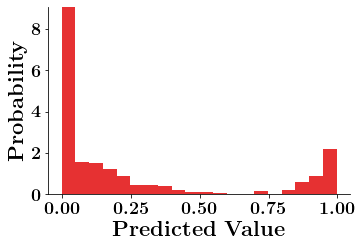

In [54]:
genplt.plot_histogram(model.predict(X_valid[...,np.newaxis])[np.argwhere(Y_valid == 0),0],[''],
               'Predicted Value',
               'Probability',
               'cnn_mlp_classifier_predict',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)

In [36]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_mlp_classifier(
                   hidden_nodes,
                   input_shape,
                   classes,
                   ):
    
    mlp = Sequential()
    mlp.add(Input(shape=input_shape))
    mlp.add(Flatten())
    
    for i in range(len(hidden_nodes)):
        if i == 0:
            mlp.add(Dense(hidden_nodes[i], 
                              activation='selu'))
        else:
            mlp.add(Dense(hidden_nodes[i], activation='selu'))
            
    mlp.add(Dense(classes,activation='softmax'))
        
    return mlp

In [41]:
if os.path.isfile('data/MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('data/MLP.h5')
    print(model.summary())
else:
    input_shape = [1024]
    dense_nodes = [512,64]

    # model,encoder,decoder = create_vae(param_dict)
    # model = create_classifier(param_dict)
    num_classes = 2

    model = create_mlp_classifier(dense_nodes,input_shape,num_classes)


    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy'])
    loss = model.fit(
                X_train,np.hstack((Y_train[...,np.newaxis],np.abs(Y_train[...,np.newaxis] - 1))),
#                 validation_split=0.2,
                validation_data=(X_valid,np.hstack((Y_valid[...,np.newaxis],np.abs(Y_valid[...,np.newaxis] - 1)))),
                epochs=20,
                batch_size=8,
                verbose=1)

#     model.save('data/MLP.h5',save_format='tf')


    
Y_mlp_valid_pred = model.predict(X_valid)
Y_mlp_train_pred = model.predict(X_train)

Y_mlp_train_pred = np.argmin(Y_mlp_train_pred,axis=1)
Y_mlp_valid_pred = np.argmin(Y_mlp_valid_pred,axis=1)

Train on 1400 samples, validate on 1400 samples
Epoch 1/20
1400/1400 [==============================] - 1s 444us/sample - loss: 0.8370 - accuracy: 0.5293 - val_loss: 0.7044 - val_accuracy: 0.5000
Epoch 2/20
1400/1400 [==============================] - 0s 311us/sample - loss: 0.6364 - accuracy: 0.6171 - val_loss: 0.6933 - val_accuracy: 0.4879
Epoch 3/20
1400/1400 [==============================] - 0s 314us/sample - loss: 0.4818 - accuracy: 0.7629 - val_loss: 0.8807 - val_accuracy: 0.5871
Epoch 4/20
1400/1400 [==============================] - 0s 330us/sample - loss: 0.3842 - accuracy: 0.8086 - val_loss: 0.8618 - val_accuracy: 0.6157
Epoch 5/20
1400/1400 [==============================] - 0s 322us/sample - loss: 0.3273 - accuracy: 0.8636 - val_loss: 0.9870 - val_accuracy: 0.5900
Epoch 6/20
1400/1400 [==============================] - 0s 307us/sample - loss: 0.2174 - accuracy: 0.9114 - val_loss: 1.7468 - val_accuracy: 0.5500
Epoch 7/20
1400/1400 [==============================] - 0s 316us

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_37 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 130       
Total params: 557,762
Trainable params: 557,762
Non-trainable params: 0
_________________________________________________________________


In [211]:
model.predict(X_valid)

array([[0.8711518 , 0.12884818],
       [0.9697277 , 0.03027232],
       [0.03558971, 0.96441036],
       ...,
       [0.9530926 , 0.04690747],
       [0.83031785, 0.16968213],
       [0.9673866 , 0.03261336]], dtype=float32)

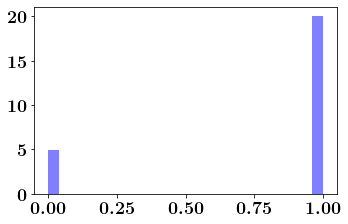

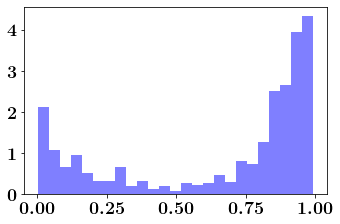

In [212]:
model.predict(X_valid)[np.argwhere(Y_valid == 0),0]
plt.hist(Y_mlp_valid_pred, 25, density=True, facecolor='b', alpha=0.50,label='Anomalous')
plt.show()

plt.hist(model.predict(X_valid)[np.argwhere(Y_valid == 0),0], 25, density=True, facecolor='b', alpha=0.50,label='Anomalous')
plt.show()

In [213]:

conf_matrix_mlp_valid = confusion_matrix(Y_valid, Y_mlp_valid_pred)
accuracy_mlp_valid = np.sum(np.diagonal(conf_matrix_mlp_valid)) / np.sum(conf_matrix_mlp_valid)
print(conf_matrix_mlp_valid)
print(accuracy_mlp_valid)

conf_matrix_mlp_train = confusion_matrix(Y_train, Y_mlp_train_pred)
accuracy_mlp_train = np.sum(np.diagonal(conf_matrix_mlp_train)) / np.sum(conf_matrix_mlp_train)
print(conf_matrix_mlp_train)
print(accuracy_mlp_train)

[[206 494]
 [ 69 631]]
0.5978571428571429
[[681  19]
 [ 53 647]]
0.9485714285714286


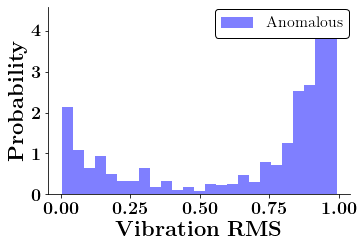

In [214]:


num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(6,4))
ax = plt.gca()
# the histogram of the data
# n, bins, patches = plt.hist(proba_test[:int(np.argwhere(y_true_test == 0)[-1]),0], 25, density=True, facecolor='b', alpha=0.50,label='Nominal')
# n, bins, patches = plt.hist(predict_mean[:int(np.argwhere(y_true_test == 0)[-1]),0], 25, density=True, facecolor='r', alpha=0.50,label='Nominal')

n, bins, patches = plt.hist(model.predict(X_valid)[np.argwhere(Y_valid == 0),0], 25, density=True, facecolor='b', alpha=0.50,label='Anomalous')
# n, bins, patches = plt.hist(predict_mean[int(np.argwhere(y_true_test == 0)[-1]):,0], 25, density=True, facecolor='r', alpha=0.50,label='Anomalous')

# n, bins, patches = plt.hist(proba_test[int(np.argwhere(y_true_test == 0)[-1]):,1], 10, density=True, facecolor='r', alpha=0.50,label='Anominal')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Vibration RMS}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(False)
# plt.savefig('Figures/RMS_Anomalous_Compare.png',transparent=True)  
plt.show()

In [215]:
import tflite_runtime.interpreter as tflite
# Load TFLite model and allocate tensors.
interpreter = tflite.Interpreter(model_path='data/CNN-MLP.tflite')

def tflite_inference(data,tflite_interpreter):
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Test model on random input data.
    input_shape = input_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    input_data = data[:,np.newaxis,:,np.newaxis].astype(np.float32)

    output_shape = output_details[0]['shape']
    num_samples = input_data.shape[0]
    all_outputs = np.zeros((num_samples,output_shape[1]))

    for i in range(num_samples):

        interpreter.set_tensor(input_details[0]['index'], input_data[i,...])
        interpreter.invoke()

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index']).flatten()

        all_outputs[i,:] = output_data
        
    return all_outputs



In [216]:
Y_cnn_lite_train_pred = tflite_inference(X_train,interpreter)
Y_cnn_lite_valid_pred = tflite_inference(X_valid,interpreter)

Y_cnn_lite_train_pred = np.argmin(Y_cnn_lite_train_pred,axis=1)
Y_cnn_lite_valid_pred = np.argmin(Y_cnn_lite_valid_pred,axis=1)

In [217]:
conf_matrix_cnn_lite_valid = confusion_matrix(Y_valid, Y_cnn_lite_valid_pred)
accuracy_cnn_lite_valid = np.sum(np.diagonal(conf_matrix_cnn_lite_valid)) / np.sum(conf_matrix_cnn_lite_valid)
print(conf_matrix_cnn_lite_valid)
print(accuracy_cnn_lite_valid)

conf_matrix_cnn_lite_train = confusion_matrix(Y_train, Y_cnn_lite_train_pred)
accuracy_cnn_lite_train = np.sum(np.diagonal(conf_matrix_cnn_lite_train)) / np.sum(conf_matrix_cnn_lite_train)
print(conf_matrix_cnn_lite_train)
print(accuracy_cnn_lite_train)

[[448 252]
 [202 498]]
0.6757142857142857
[[700   0]
 [  0 700]]
1.0
